# ENGR-E 533: Deep Learning Systems
## Homework 2

### Khandokar Md. Nayem (knayem@iu.edu)
### Mar 28, 2018

### Import necessary files and set environment parameters
My assigned Node is `r-005` and GPU `0`.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import time

import matplotlib.pyplot as plt

### Importing MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Global Parameters

In [3]:
NUM_ITERATION = 10000 # Number of iteration number in Train
TRAIN_BATCH_SIZE = 1000 # Sample 1000 Train batch
TEST_BATCH_SIZE = 1000 # Sample 1000 Test batch

### Xavier Initialization of Weights
These are the weight initialization function used in defining model.

In [4]:
def weight_variable (shape):
    initial = tf.truncated_normal(shape, stddev = np.sqrt(2.0/sum(shape)) )
    return tf.Variable(initial)

def bias_variable (shape):
    initial = tf.truncated_normal(shape, stddev = np.sqrt(1.0/sum(shape)) )
    return tf.Variable(initial)

### Create the fully connected model 

In [5]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10]) # original

W_1 = weight_variable([784, 1024])
b_1 = bias_variable([1024])

W_2 = weight_variable([1024, 1024])
b_2 = bias_variable([1024])

W_3 = weight_variable([1024, 1024])
b_3 = bias_variable([1024])

W_4 = weight_variable([1024, 1024])
b_4 = bias_variable([1024])

W_5 = weight_variable([1024, 1024])
b_5 = bias_variable([1024])

W_6 = weight_variable([1024, 10])
b_6 = bias_variable([10])


# Layer connections and Activation functions
y_1 = tf.nn.relu(tf.matmul(x, W_1) + b_1)
y_2 = tf.nn.relu(tf.matmul(y_1, W_2) + b_2)
y_3 = tf.nn.relu(tf.matmul(y_2, W_3) + b_3)
y_4 = tf.nn.relu(tf.matmul(y_3, W_4) + b_4)
y_5 = tf.nn.relu(tf.matmul(y_4, W_5) + b_5)
y = tf.matmul(y_5, W_6) + b_6 # predicted



# Define loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

### Run the model (Q1, Q2)
On average, `Accuracy` on test batch is over `98% (98.51%)` . If we increase the number of iteration (Line 10, currently 10000), `Accuracy` increases; but more time is needed to train.

In [6]:
# Configuration to control GPU use
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.33
# sess = tf.InteractiveSession(config=config)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


# Train Model
s = time.time()

for _ in range(NUM_ITERATION):
    batch_xs, batch_ys = mnist.train.next_batch(TRAIN_BATCH_SIZE)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

print('Training Time(sec):', time.time()-s)
    
    
# Test trained model
s = time.time()
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy:",sess.run(accuracy, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels}))

print('Testing Time(sec):', time.time()-s)

Training Time(sec): 80.57156419754028
Accuracy: 0.9851
Testing Time(sec): 0.2075037956237793


### SVD (Q3, Q4, Q5)

Here we define the model for testing using SVD. We can test the above model for any `D` value.

In [7]:
d = tf.placeholder(tf.int32, [None])

def svd_weight(w, D):
    D = D[0]
    s, u, v = tf.svd(w)
    temp = u[:,:D] @ tf.diag(s[:D])
    vT = tf.transpose(v[:,:D])
    u, svT = u[:,:D], tf.diag(s[:D])@vT
    return u, svT, tf.matmul(temp,vT)


def svd_model(x,y_, w1,b1,w2,b2,w3,b3,w4,b4,w5,b5,w6,b6, D):
    u_1, svT_1, w_1 = svd_weight(w1,D)
    b_1 = b1

    u_2, svT_2, w_2 = svd_weight(w2,D)
    b_2 = b2

    u_3, svT_3, w_3 = svd_weight(w3,D)
    b_3 = b3

    u_4, svT_4, w_4 = svd_weight(w4,D)
    b_4 = b4

    u_5, svT_5, w_5 = svd_weight(w5,D)
    b_5 = b5

    w_6 = w6
    b_6 = b6


    # Layer connections and Activation functions
    y_1 = tf.nn.relu(tf.matmul(x, w_1) + b_1)
    y_2 = tf.nn.relu(tf.matmul(y_1, w_2) + b_2)
    y_3 = tf.nn.relu(tf.matmul(y_2, w_3) + b_3)
    y_4 = tf.nn.relu(tf.matmul(y_3, w_4) + b_4)
    y_5 = tf.nn.relu(tf.matmul(y_4, w_5) + b_5)
    y = tf.matmul(y_5, w_6) + b_6 # predicted

    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return u_1, svT_1, b_1, u_2, svT_2, b_2, u_3, svT_3, b_3, u_4, svT_4, b_4, u_5, svT_5, b_5, w_6, b_6, accuracy


u1, svT1, b1, u2, svT2, b2, u3, svT3, b3, u4, svT4, b4, u5, svT5, b5, w6, b6, acc = svd_model(x,y_, W_1,b_1,W_2,b_2,W_3,b_3,W_4,b_4,W_5,b_5,W_6,b_6, d)

To see how accuracy changes, here we generate points for `D` values. (D vs accuracy).

In [8]:
a = []
point_interval = 100

# Plot graph in 100 interval, (10-1024)
for d_val in np.arange(10,1024,point_interval):
    s = time.time()
    a.append(sess.run(acc, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels, d:[d_val]}))
    
    print('D:',d_val, ', Accuracy:', a[-1], ', Time(sec):', time.time()-s)


print('Accuracy:', a)

D: 10 , Accuracy: 0.628 , Time(sec): 13.21485710144043
D: 110 , Accuracy: 0.985 , Time(sec): 12.974938869476318
D: 210 , Accuracy: 0.9848 , Time(sec): 12.694153547286987
D: 310 , Accuracy: 0.9852 , Time(sec): 12.605869770050049
D: 410 , Accuracy: 0.9852 , Time(sec): 13.061028718948364
D: 510 , Accuracy: 0.9853 , Time(sec): 12.69934368133545
D: 610 , Accuracy: 0.9852 , Time(sec): 13.81065821647644
D: 710 , Accuracy: 0.9851 , Time(sec): 13.746222019195557
D: 810 , Accuracy: 0.9852 , Time(sec): 13.230849981307983
D: 910 , Accuracy: 0.9851 , Time(sec): 12.636778354644775
D: 1010 , Accuracy: 0.9851 , Time(sec): 12.621330499649048
Accuracy: [0.628, 0.985, 0.9848, 0.9852, 0.9852, 0.9853, 0.9852, 0.9851, 0.9852, 0.9851, 0.9851]


Plot the graph.

<IPython.core.display.Javascript object>


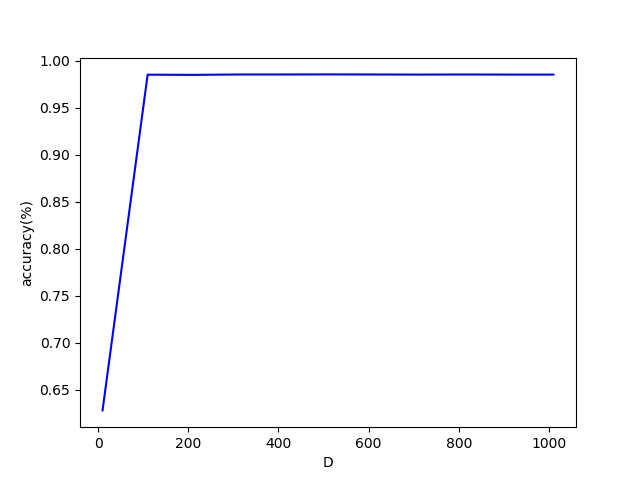

In [9]:
%matplotlib notebook
plt.figure('Plot: Accuracy vs D')
plt.plot(np.arange(10,1024,point_interval), a, 'b-')
plt.xlabel("D")
plt.ylabel("accuracy(%)")
plt.show()

Here we explicitly show the Accuracy for `D = 10, 20, 50, 100, 200, full.`

In [10]:
s = time.time()
print("[D=10]   Accuracy:",sess.run(acc, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels, d:[10]}), ', Time(sec):', time.time()-s)
s = time.time()
print("[D=20]   Accuracy:",sess.run(acc, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels, d:[20]}), ', Time(sec):', time.time()-s)
s = time.time()
print("[D=50]   Accuracy:",sess.run(acc, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels, d:[50]}), ', Time(sec):', time.time()-s)
s = time.time()
print("[D=100]  Accuracy:",sess.run(acc, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels, d:[100]}), ', Time(sec):', time.time()-s)
s = time.time()
print("[D=200]  Accuracy:",sess.run(acc, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels, d:[200]}), ', Time(sec):', time.time()-s)
s = time.time()
print("[D=full] Accuracy:",sess.run(acc, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels, d:[1024]}), ', Time(sec):', time.time()-s)

[D=10]   Accuracy: 0.628 , Time(sec): 12.642799377441406
[D=20]   Accuracy: 0.9244 , Time(sec): 12.594072103500366
[D=50]   Accuracy: 0.9805 , Time(sec): 12.898000478744507
[D=100]  Accuracy: 0.9846 , Time(sec): 12.866013765335083
[D=200]  Accuracy: 0.9849 , Time(sec): 12.99941611289978
[D=full] Accuracy: 0.9851 , Time(sec): 12.799878358840942


### Q6 (Approach-a) 

Here we get the initialized values from the previous model and initialize it. And the we create a new model graph. And then we train the model for same number of Epochs. We get the accuracy of `98.1%`.

In [11]:
D = 20

u1, svT1, b1, u2, svT2, b2, u3, svT3, b3, u4, svT4, b4, u5, svT5, b5, w6, b6 = sess.run([u1, svT1, b1, u2, svT2, b2, u3, svT3, b3, u4, svT4, b4, u5, svT5, b5, w6, b6], feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels, d:[D]})  

In [12]:
# x = tf.placeholder(tf.float32, [None, 784])
# y_ = tf.placeholder(tf.float32, [None, 10]) # original

# Define tensors with initialization: u and svT 
d_u_1 = tf.Variable(u1)
d_svT_1 = tf.Variable(svT1)

d_u_2 = tf.Variable(u2)
d_svT_2 = tf.Variable(svT2)

d_u_3 = tf.Variable(u3)
d_svT_3 = tf.Variable(svT3)

d_u_4 = tf.Variable(u4)
d_svT_4 = tf.Variable(svT4)

d_u_5 = tf.Variable(u5)
d_svT_5 = tf.Variable(svT5)


# Define tensors with initialization: W and b
# d_W_1 = d_u_1@d_svT_1
d_b_1 = tf.Variable(b1)

# d_W_2 = d_u_2@d_svT_2
d_b_2 = tf.Variable(b2)

# d_W_3 = d_u_3@d_svT_3
d_b_3 = tf.Variable(b3)

# d_W_4 = d_u_4@d_svT_4
d_b_4 = tf.Variable(b4)

# d_W_5 = d_u_5@d_svT_5
d_b_5 = tf.Variable(b5)

d_W_6 = tf.Variable(w6)
d_b_6 = tf.Variable(b6)

# Layer connections and Activation functions
d_y_1 = tf.nn.relu(tf.matmul(x, d_u_1@d_svT_1) + d_b_1)
d_y_2 = tf.nn.relu(tf.matmul(d_y_1, d_u_2@d_svT_2) + d_b_2)
d_y_3 = tf.nn.relu(tf.matmul(d_y_2, d_u_3@d_svT_3) + d_b_3)
d_y_4 = tf.nn.relu(tf.matmul(d_y_3, d_u_4@d_svT_4) + d_b_4)
d_y_5 = tf.nn.relu(tf.matmul(d_y_4, d_u_5@d_svT_5) + d_b_5)
d_y = tf.matmul(d_y_5, d_W_6) + d_b_6 # predicted


# # Layer connections and Activation functions
# d_y_1 = tf.nn.relu(tf.matmul(x, d_W_1) + d_b_1)
# d_y_2 = tf.nn.relu(tf.matmul(d_y_1, d_W_2) + d_b_2)
# d_y_3 = tf.nn.relu(tf.matmul(d_y_2, d_W_3) + d_b_3)
# d_y_4 = tf.nn.relu(tf.matmul(d_y_3, d_W_4) + d_b_4)
# d_y_5 = tf.nn.relu(tf.matmul(d_y_4, d_W_5) + d_b_5)
# d_y = tf.matmul(d_y_5, d_W_6) + d_b_6 # predicted



# Define loss and optimizer
d_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=d_y))
d_train_step = tf.train.AdamOptimizer().minimize(d_cross_entropy)

In [13]:
tf.global_variables_initializer().run()


# Train Model
s = time.time()
for _ in range(NUM_ITERATION):
    batch_xs, batch_ys = mnist.train.next_batch(TRAIN_BATCH_SIZE)
    sess.run(d_train_step, feed_dict={x: batch_xs, y_: batch_ys})
    
print('Training Time(sec):', time.time()-s)
    
    
# Test trained model
s = time.time()
d_correct_prediction = tf.equal(tf.argmax(d_y, 1), tf.argmax(y_, 1))
d_accuracy = tf.reduce_mean(tf.cast(d_correct_prediction, tf.float32))

print("Accuracy:",sess.run(d_accuracy, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels}))

print('Testing Time(sec):', time.time()-s)

Training Time(sec): 78.60291123390198
Accuracy: 0.981
Testing Time(sec): 0.05290865898132324
